# <b>CS156 (Introduction to AI), Spring 2022</b>
# <u><b>Homework 8 submission</b></u>

### Roster Name: Andrew Vu
### Student ID: 015055911
### Email address: andrew.k.vu@sjsu.edu
Any special notes or anything you would like to communicate to me about this homework submission goes in here.

##  <u>References and sources </u>

List all your references and sources here.
This includes all sites/discussion boards/blogs/posts/etc. where you grabbed some code examples.
- CNN.Dog_vs_cat_images from your examples
- https://www.kaggle.com/grfiv4/plot-a-confusion-matrix
- https://stackoverflow.com/questions/64687375/get-labels-from-dataset-when-using-tensorflow-image-dataset-from-directory

##  <u>Solution</u>

#### Load libraries and set random number generator seed

In [103]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import os
import matplotlib.pyplot as plt
# import pydot
from skimage import io
import numpy as np
import itertools

In [104]:
np.random.seed(42)

#### Code the solution

### Loading Dataset Images

In [105]:
image_size = (180, 180)
batch_size = 32

print("Training data: ")
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "./hw8useful/homework8_input_data/flowers/training",
    labels='inferred',
    label_mode='categorical',
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=image_size,
    batch_size=batch_size,
)

print("\nValidation data: ")
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "./hw8useful/homework8_input_data/flowers/training",
    labels='inferred',
    label_mode='categorical',
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=image_size,
    batch_size=batch_size,
)

print("\nTest data: ")
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "./hw8useful/homework8_input_data/flowers/test",
    labels='inferred',
    label_mode='categorical',
    seed=42,
    image_size=image_size,
    batch_size=1,
)



Training data: 
Found 3456 files belonging to 5 classes.
Using 2765 files for training.

Validation data: 
Found 3456 files belonging to 5 classes.
Using 691 files for validation.

Test data: 
Found 861 files belonging to 5 classes.


### Augment the data

In [106]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

### Define model architecture

In [107]:
# FROM CNN.Dog_vs_cat_images file
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 5:
        activation = "sigmoid"
        units = 5
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=5)
#keras.utils.plot_model(model, show_shapes=True)
model.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 180, 180, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential_9 (Sequential)      (None, 180, 180, 3)  0           ['input_10[0][0]']               
                                                                                                  
 rescaling_9 (Rescaling)        (None, 180, 180, 3)  0           ['sequential_9[0][0]']           
                                                                                                  
 conv2d_54 (Conv2D)             (None, 90, 90, 32)   896         ['rescaling_9[0][0]']      

 Conv2D)                                                                                          
                                                                                                  
 batch_normalization_106 (Batch  (None, 23, 23, 512)  2048       ['separable_conv2d_86[0][0]']    
 Normalization)                                                                                   
                                                                                                  
 max_pooling2d_38 (MaxPooling2D  (None, 12, 12, 512)  0          ['batch_normalization_106[0][0]']
 )                                                                                                
                                                                                                  
 conv2d_58 (Conv2D)             (None, 12, 12, 512)  131584      ['add_37[0][0]']                 
                                                                                                  
 add_38 (A

### Train the model

In [108]:
epochs = 20

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)

Epoch 1/20
87/87 [==============================] - 196s 2s/step - loss: 1.2704 - accuracy: 0.5266 - val_loss: 1.6723 - val_accuracy: 0.2590
Epoch 2/20
87/87 [==============================] - 194s 2s/step - loss: 0.9803 - accuracy: 0.6347 - val_loss: 2.0438 - val_accuracy: 0.2590
Epoch 3/20
87/87 [==============================] - 194s 2s/step - loss: 0.8981 - accuracy: 0.6665 - val_loss: 2.8017 - val_accuracy: 0.2590
Epoch 4/20
87/87 [==============================] - 194s 2s/step - loss: 0.8464 - accuracy: 0.6828 - val_loss: 3.5591 - val_accuracy: 0.2590
Epoch 5/20
87/87 [==============================] - 194s 2s/step - loss: 0.7598 - accuracy: 0.7251 - val_loss: 4.0505 - val_accuracy: 0.2590
Epoch 6/20
87/87 [==============================] - 195s 2s/step - loss: 0.7648 - accuracy: 0.7175 - val_loss: 1.9164 - val_accuracy: 0.3184
Epoch 7/20
87/87 [==============================] - 195s 2s/step - loss: 0.6780 - accuracy: 0.7432 - val_loss: 1.6610 - val_accuracy: 0.5109
Epoch 8/20
87

### Evaluate the model

In [109]:
score = model.evaluate(test_ds)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

861/861 [==============================] - 20s 23ms/step - loss: 0.9867 - accuracy: 0.6864
Test loss: 0.9867478609085083
Test accuracy: 0.6864111423492432


### Going through test data imageset

In [110]:
predicted_labels = np.array([])
true_labels = np.array([])
label_names = ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

for x, y in test_ds:
    predicted_labels = np.concatenate([predicted_labels, np.argmax(model.predict(x), axis = -1)])
    true_labels = np.concatenate([true_labels, np.argmax(y.numpy(), axis=-1)])

cm = tf.math.confusion_matrix(labels=true_labels, predictions=predicted_labels).numpy() 
print(cm)

[[ 88  36   7   7  15]
 [  7 188   4   5   6]
 [  0  11  53   3  89]
 [  1  29   3 105   8]
 [  3  13  11  12 157]]


### Plotting confusion matrix

In [111]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """


    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

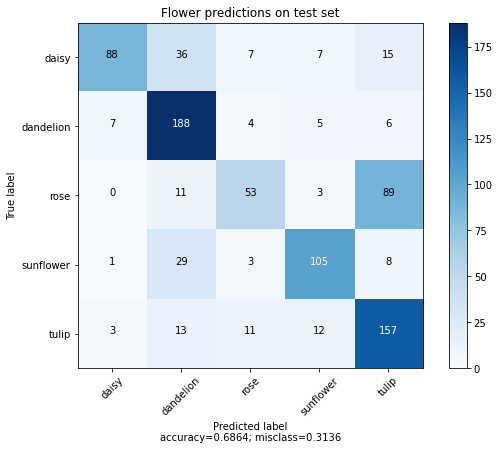

In [112]:
plot_confusion_matrix(cm = cm, 
                      normalize = False, 
                      target_names = label_names,
                      title = 'Flower predictions on test set')

In [113]:
print(predicted_labels)
print(true_labels)
print(len(predicted_labels))

[4. 3. 1. 0. 1. 1. 3. 3. 1. 1. 1. 2. 1. 2. 3. 1. 1. 1. 4. 4. 4. 1. 4. 4.
 4. 2. 3. 1. 4. 1. 0. 1. 0. 4. 3. 4. 1. 0. 1. 1. 1. 2. 4. 1. 2. 3. 4. 3.
 2. 3. 4. 1. 1. 4. 3. 4. 0. 1. 1. 2. 1. 0. 2. 1. 4. 4. 1. 4. 3. 4. 1. 4.
 4. 3. 1. 3. 3. 4. 4. 0. 4. 1. 4. 1. 3. 1. 1. 3. 1. 0. 3. 3. 4. 3. 4. 4.
 4. 4. 4. 3. 1. 3. 4. 0. 3. 1. 3. 4. 0. 4. 0. 1. 1. 1. 1. 1. 3. 4. 4. 4.
 4. 3. 0. 1. 4. 4. 1. 4. 2. 1. 2. 4. 1. 4. 3. 4. 2. 0. 4. 4. 0. 0. 1. 4.
 0. 1. 3. 1. 1. 2. 3. 0. 1. 1. 0. 4. 4. 4. 1. 1. 3. 2. 1. 1. 0. 4. 0. 2.
 1. 1. 3. 1. 1. 1. 2. 4. 4. 4. 0. 1. 2. 2. 3. 1. 4. 1. 1. 4. 3. 3. 3. 4.
 4. 0. 4. 1. 2. 4. 0. 4. 4. 1. 1. 4. 3. 1. 4. 4. 3. 2. 4. 3. 4. 3. 0. 0.
 4. 4. 1. 1. 1. 2. 4. 4. 0. 3. 0. 3. 1. 2. 4. 3. 4. 1. 3. 4. 2. 4. 1. 1.
 1. 3. 4. 0. 4. 4. 4. 0. 3. 4. 1. 0. 1. 0. 3. 1. 4. 4. 4. 4. 1. 1. 0. 1.
 1. 4. 4. 1. 3. 1. 1. 0. 0. 3. 4. 1. 1. 1. 1. 1. 1. 4. 0. 3. 4. 4. 2. 1.
 2. 4. 2. 3. 4. 3. 1. 1. 4. 1. 3. 3. 1. 3. 3. 4. 3. 4. 1. 1. 1. 0. 4. 1.
 4. 4. 1. 4. 3. 0. 0. 1. 4. 4. 4. 1. 3. 1. 4. 0. 4.

### Examples of misclassified images

daisy: 4.419979453086853 dandelion: 99.74010586738586 rose: 6.566828489303589 sunflower: 57.685184478759766 tulip: 19.940277934074402


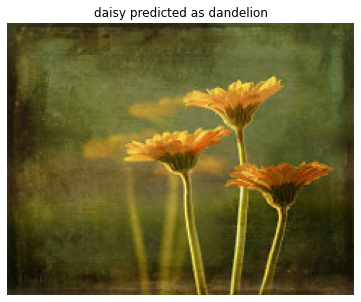

In [118]:
url = './hw8useful/homework8_input_data/flowers/test/daisy/34508227161_a9ff840f71_n.jpg'

img = io.imread(url)
plt.figure(figsize=(8, 5))
plt.axis("off")
plt.title("daisy predicted as dandelion")
plt.imshow(img)

# label_names = ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']
img = keras.preprocessing.image.load_img(
    url, target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = predictions[0]
# print(
#     "This image is %.2f percent cat and %.2f percent dog."
#     % (100 * (1 - score), 100 * score)
# )
print('daisy: ' + str(score[0] * 100), 
      'dandelion: ' + str(score[1] * 100), 
      'rose: ' + str(score[2] * 100), 
      'sunflower: ' + str(score[3] * 100), 
      'tulip: ' + str(score[4] * 100))

daisy: 26.46360993385315 dandelion: 78.54951620101929 rose: 62.350279092788696 sunflower: 5.901333689689636 tulip: 71.77703380584717


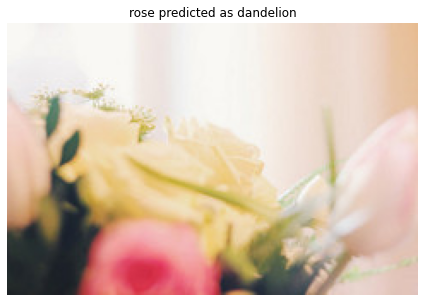

In [115]:
url = './hw8useful/homework8_input_data/flowers/test/rose/17105684129_e2cb69ea24_n.jpg'

img = io.imread(url)
plt.figure(figsize=(8, 5))
plt.axis("off")
plt.title("rose predicted as dandelion")
plt.imshow(img)

# label_names = ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']
img = keras.preprocessing.image.load_img(
    url, target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = predictions[0]
# print(
#     "This image is %.2f percent cat and %.2f percent dog."
#     % (100 * (1 - score), 100 * score)
# )
print('daisy: ' + str(score[0] * 100), 
      'dandelion: ' + str(score[1] * 100), 
      'rose: ' + str(score[2] * 100), 
      'sunflower: ' + str(score[3] * 100), 
      'tulip: ' + str(score[4] * 100))

daisy: 28.46115231513977 dandelion: 77.77357697486877 rose: 26.94074511528015 sunflower: 31.566447019577026 tulip: 61.55676245689392


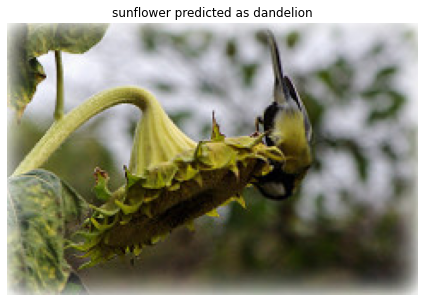

In [125]:
url = './hw8useful/homework8_input_data/flowers/test/sunflower/21899501660_7065d1c1fa_n.jpg'

img = io.imread(url)
plt.figure(figsize=(8, 5))
plt.axis("off")
plt.title("sunflower predicted as dandelion")
plt.imshow(img)

# label_names = ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']
img = keras.preprocessing.image.load_img(
    url, target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = predictions[0]
# print(
#     "This image is %.2f percent cat and %.2f percent dog."
#     % (100 * (1 - score), 100 * score)
# )
print('daisy: ' + str(score[0] * 100), 
      'dandelion: ' + str(score[1] * 100), 
      'rose: ' + str(score[2] * 100), 
      'sunflower: ' + str(score[3] * 100), 
      'tulip: ' + str(score[4] * 100))